# Convolutions

In this notebook, we explore the concept of convolutional neural networks.


You may want to read this [wikipedia page](https://en.wikipedia.org/wiki/Convolution) if you're not familiar with the concept of a convolution.

In a convolutional neural network 

### 1. Definition of the (discrete) convolution

You may read Wikipedia's [web page](https://en.wikipedia.org/wiki/Convolution#Discrete_convolution)

I we consider two functions $f$ and $g$ taking values from $\mathbb{Z} \to \mathbb{R}$ then:  
$ (f * g)[n] = \sum_{m = -\infty}^{+\infty} f[m] \cdot g[n - m] $

In our case, we consider the two vectors $x$ and $w$ :  
$ x = (x_1, x_2, ..., x_{n-1}, x_n) $  
$ w = (w_1, w_2) $

And get :   
$ x * w = (w_1 x_1 + w_2 x_2, w_1 x_2 + w_2 x_3, ..., w_1 x_{n-1} + w_2 x_n)$


#### Deep learning subtility :
    
In most of deep learning framewoks, you'll get to chose in between three paddings:
- **Same**: $(f*g)$ has the same shape as x (we pad the entry with zeros)
- **valid**: $(f*g)$ has the shape of x minus the shape of w plus 1 (no padding on x)
- **Causal**: $(f*g)(n_t)$ does not depend on any $(n_{t+1})$

In [122]:
# Which is easily implemented on python :
def _convolve(x, w, type='valid'):
    # x and w are np vectors
    conv = []
    for i in range(len(x)):
        if type == 'valid':
            conv.append((x[i: i+len(w)] * w).sum())
    return np.array(conv)

def convolve(X, w):
    # Convolves a batch X to w
    w = np.array(w)
    X = np.array(X)
    conv = []
    for i in range(len(X)):
        conv.append(_convolve(X[i], w))
    return np.array(conv)

### 2. Derive the Convolution !!

As we use it, the convolution is parametrised by two vectors $x$ and $w$ and outputs a vector $z$. We have:  
$ x * w = z$  
$ z_i = (w_1 x_i + w_2 x_{i+1})$

We want to derive $z$ with respect to some weights $w_j$:  
$\frac{\delta z_i}{\delta w_j} = x_{i+j}$  
$\frac{\delta z_i}{\delta w} = (x_{i}, x_{i+1}, ..., x_{i+n})$


### Example of convolutions :

We consider a classification problem where we want to distinguish 2 signals. One is going upward and the other is going downwards

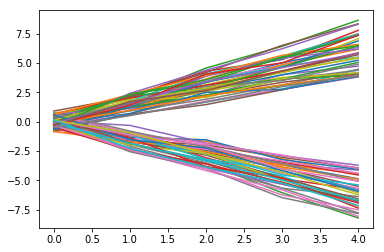

In [113]:
from utils import *
import utils
reload(utils)
from utils import *

(x_train, y_train), (x_test, y_test) = load_up_down(50)

plt.plot(x_train.T)
plt.show()

### Train a convolutional neural net

In [120]:
# Rename y_silver to X and y_gold to Y
X, Y = [x_train, ], y_train

# Initilize the parameters
Ws = [0.5, 0.5]
alphas = (0.01, 0.01)

# Load Trainer
t = Trainer(X, Y, Ws, alphas)

# Define Prediction and Loss
t.pred = lambda X : convolve(X[0], (t.Ws[0], t.Ws[1])).mean(axis=1)
t.loss = lambda : (np.power((t.Y - t.pred(t.X)), 2) * 1 / 2.).mean()

print t.pred(X)

t.acc = lambda X, Y : t.pred(X)

# Define the gradient functions
dl_dp = lambda : -(t.Y - t.pred(X))
dl_dw0 = lambda : (t.X[0][:-1]).mean()
dl_dw1 = lambda : (t.X[0][1:]).mean()
t.dWs = (dl_dw0, dl_dw1)

# Start training
anim = t.animated_train(is_notebook=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

[-2.95406229 -4.19995715 -4.92530171 -3.50843385  2.93579084 -2.56558233
 -3.48516972  2.60467981  4.01417791 -4.0054429   3.86312917 -2.54467932
  5.23706384  3.66563201 -2.59664335 -3.27605571  3.88520904 -4.17058436
  2.75610825  2.27116778 -2.45068013 -2.85053277  3.03680474 -2.77400282
 -3.25077335 -3.78010717 -2.81143358  2.53485896  3.37978371  3.63635815
  3.05598171  4.38895028  2.55824429  4.75282841 -2.12001702  2.5578903
  2.12228123 -4.61087264 -3.34176093 -3.36233701  4.27055424  3.62796788
  2.61407448  3.71904341 -4.38617731  2.11048098 -4.91564831 -4.97141649
  2.83468762  4.50311477  3.91891824 -3.10778125  3.91287806 -4.36980475
  4.05013498  5.15783262 -2.26405096 -2.75767488 -3.9981223  -3.4486342
  2.28003072  4.42729874  4.17765023 -4.20374588  5.0555809  -4.08053761
 -4.82339603  3.0842374   3.42749075 -4.0597609  -3.32068842  2.43119417
  4.45859926  4.28075668  3.66046429  3.41725256 -2.95180196  2.18222808
 -3.45469694 -4.41320597]


In [117]:
t.loss()


0.19535109550921673

### Applied to image

We demonstrate how 2D convolutions applies to images (In this case, we designe the kernels of the conlutions).

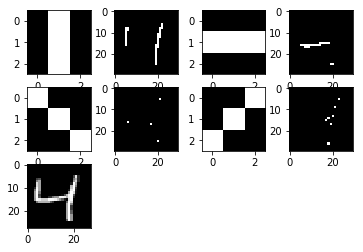

In [42]:
from scipy import signal

# Load MNIST
(x_train, y_train), (x_test, y_test) = load_MNIST()
img = x_train[2]

# Design the kernels
kernels = [[[-1, 2, -1],[-1, 2, -1],[-1, 2, -1]],
           [[-1, -1, -1],[2, 2, 2],[-1, -1, -1]],
           [[2, -1, -1],[-1, 2, -1],[-1, -1, 2]],
           [[-1, -1, 2],[-1, 2, -1],[2, -1, -1]], ]

# Plot and convolve them to the image
for i, k in enumerate(kernels):
    i = i*2+1
    plt.subplot(3,4,i)
    plt.imshow(k, cmap='gray')
    plt.subplot(3,4,i+1)
    conv = signal.convolve2d(img, k)
    plt.imshow(conv > 1.5, cmap='gray')

plt.subplot(349)
plt.imshow(img, cmap='gray')
plt.show()
